In [1]:
"""Progetto_gruppo3.ipynb
"""

#%% IMPORT SECTION
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble 
from sklearn import tree

#%% DIRECTORY SETTINGS
# Change work directory
os.chdir('//srv0001/Risorse/Public/Gruppo3-Python')
cwd = os.getcwd()
print(cwd)


#%% PREPARE FUNCTION
def prepare_data(data):
   
    features = data.drop(["REF_DATE", "SEDOLCHK", "ICB_INDUSTRY_NUM", "ICB_SECTOR_NUM"], axis=1).astype("float64")
        
    return features


\\srv0001\Risorse\Public\Gruppo3-Python


In [2]:
#%% IMPORT DATA
#Import .csv
clean_data = pd.read_csv(r'Data/clean3.csv', sep=',')

for col in clean_data.columns:
        if clean_data[col].dtype==object and col!='SEDOLCHK':
            clean_data[col]=pd.to_numeric(clean_data[col],errors='coerce')
        
companynames = pd.read_csv(r'Data/companynames.csv', sep=',')
companynames = companynames.drop_duplicates(subset = "SEDOLCHK")

#print(clean_data.head(10))

referenceDate = clean_data["REF_DATE"].drop_duplicates().reset_index(drop = True)

#print(referenceDate.tail(20))

sectors_dict = {'1':'Oil & Gas','1000':'Basic Materials','2000':'Industrial',
'3000':'Consumer Good','4000':'Health Care','5000':'Consumer Services',
'6000':'Telecomunications','7000':'Utilities','8000':'Financials',
'9000':'Technology'}

In [22]:

#%% get the rolling window
alldata = len(referenceDate.index)
months_to_train = 24;

value = np.random.randint(months_to_train+1, alldata, size=1)
value = value[0]
value = 175  

dateToCheck = referenceDate.loc[value]
startRefDate  = referenceDate.loc[value-months_to_train-1]
endRefDate = referenceDate.loc[value-1]

                                  
mywindow = clean_data[(clean_data['REF_DATE']>=startRefDate) & (clean_data['REF_DATE']<=endRefDate)]


#%% K fold using GridSearchCV
from sklearn.model_selection import GridSearchCV

features = prepare_data(mywindow)

x = features
y = mywindow['ICB_INDUSTRY_NUM']

parameters = {'max_depth':range(10,35)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=8)
clf.fit(X=x, y=y)
tree_model = clf.best_estimator_

print (clf.best_score_, clf.best_params_) 


0.7912495943092142 {'max_depth': 30}


In [4]:
#%% FIT THE REAL MODEL

model = tree.DecisionTreeClassifier(max_depth = clf.best_params_.get('max_depth'))
model.fit(features, mywindow['ICB_INDUSTRY_NUM'])


#%% GET THE OUTLIERS SEDOLCHK & names
test_last_month = clean_data[(clean_data.REF_DATE==20191129)].copy()
predicted = model.predict(prepare_data(test_last_month))
g_truth = test_last_month["ICB_INDUSTRY_NUM"].to_numpy(copy=True)

outliers_sedol = pd.DataFrame(test_last_month["SEDOLCHK"])
outliers_sedol['ICB_INDUSTRY_NUM'] = test_last_month["ICB_INDUSTRY_NUM"]
outliers_sedol['PREDICTED'] = predicted

rowtodrop = np.where(predicted == g_truth)[0]

outliers_sedol = outliers_sedol.drop(outliers_sedol.index[rowtodrop])

outliers = outliers_sedol.merge(companynames, left_on='SEDOLCHK', right_on='SEDOLCHK')

outliers["ICB_INDUSTRY_NUM"] = outliers["ICB_INDUSTRY_NUM"].astype(str)
outliers["ICB_INDUSTRY_NUM"] = outliers["ICB_INDUSTRY_NUM"].map(sectors_dict)
outliers["PREDICTED"] = outliers["PREDICTED"].astype(str)
outliers["PREDICTED"] = outliers["PREDICTED"].map(sectors_dict)

print(outliers)

outliers.to_excel(excel_writer = 'Tree_Outliers.xlsx')

   SEDOLCHK   ICB_INDUSTRY_NUM        PREDICTED                         NAME
0   5699373         Industrial    Consumer Good              WIENERBERGER AG
1   BD594Y4        Health Care       Industrial      SIEMENS HEALTHINEERS AG
2   BGBN7C0  Consumer Services       Industrial                SSP GROUP PLC
3   7117884        Health Care        Oil & Gas            BB BIOTECH AG-REG
4   BZCNB42  Consumer Services    Consumer Good             DELIVERY HERO SE
..      ...                ...              ...                          ...
89  BVZHXQ9         Financials       Industrial                   HISCOX LTD
90  4916039  Consumer Services       Industrial               AIR FRANCE-KLM
91  B6T5S47    Basic Materials       Financials  POLYMETAL INTERNATIONAL PLC
92  BSHYK55      Consumer Good       Industrial         HELLA GMBH & CO KGAA
93  4741714      Consumer Good  Basic Materials               REMY COINTREAU

[94 rows x 4 columns]


In [18]:
#%% FIT THE REAL MODEL
f_estim = 100
f_maxf = 25

forest = ensemble.RandomForestClassifier(n_estimators=f_estim, bootstrap=True, max_features=f_maxf)
forest.fit(features, mywindow["ICB_INDUSTRY_NUM"])
  
#%% GET THE OUTLIERS SEDOLCHK & names

predicted_f = forest.predict(prepare_data(test_last_month))
g_truth_f = test_last_month["ICB_INDUSTRY_NUM"].to_numpy(copy=True)

outliers_sedol_f = pd.DataFrame(test_last_month["SEDOLCHK"])
outliers_sedol_f['ICB_INDUSTRY_NUM'] = test_last_month["ICB_INDUSTRY_NUM"]
outliers_sedol_f['PREDICTED'] = predicted_f

rowtodrop_f = np.where(predicted_f == g_truth_f)[0]

outliers_sedol_f = outliers_sedol_f.drop(outliers_sedol_f.index[rowtodrop_f])

outliers_f = outliers_sedol_f.merge(companynames, left_on='SEDOLCHK', right_on='SEDOLCHK')

outliers_f["ICB_INDUSTRY_NUM"] = outliers_f["ICB_INDUSTRY_NUM"].astype(str)
outliers_f["ICB_INDUSTRY_NUM"] = outliers_f["ICB_INDUSTRY_NUM"].map(sectors_dict)
outliers_f["PREDICTED"] = outliers_f["PREDICTED"].astype(str)
outliers_f["PREDICTED"] = outliers_f["PREDICTED"].map(sectors_dict)

print(outliers_f)

outliers_f.to_excel(excel_writer = 'Forest_Outliers.xlsx')

   SEDOLCHK   ICB_INDUSTRY_NUM        PREDICTED                        NAME
0   BD594Y4        Health Care       Industrial     SIEMENS HEALTHINEERS AG
1   3302480        Health Care       Industrial          UDG HEALTHCARE PLC
2   B7KR2P8  Consumer Services       Industrial                 EASYJET PLC
3   4768962          Utilities       Industrial                      RWE AG
4   5842359  Telecomunications       Industrial     DEUTSCHE TELEKOM AG-REG
5   B09M9F4          Utilities       Financials  ELIA SYSTEM OPERATOR SA/NV
6   B09LSH6  Telecomunications  Basic Materials                INMARSAT PLC
7   BDZT6P9  Consumer Services      Health Care        MERLIN ENTERTAINMENT
8   B8C3BL0         Technology       Industrial          SAGE GROUP PLC/THE
9   5902941         Technology       Industrial                   NOKIA OYJ
10  BYT3416  Telecomunications       Industrial            ALTICE EUROPE NV
11  BVZHXQ9         Financials       Industrial                  HISCOX LTD


Feature ranking:
19. feature EBIT_SALES (0.077162)
36. feature PCF (0.062294)
16. feature DEBT_MKT_CAP (0.051609)
34. feature NM (0.047419)
35. feature PB (0.045682)
3. feature FIVE_YR_VOLATILITY_W (0.036976)
58. feature ROE (0.036523)
41. feature PCTCHG_EQUITY (0.033164)
61. feature TURNOVER_1M (0.030637)
33. feature MKT_CAP_SALES (0.030617)
2. feature FIVE_YR_VOLATILITY_M (0.029056)
13. feature CV5Y_EPS (0.028516)
5. feature AERR (0.026397)
62. feature UL_SALES (0.026280)
11. feature CV3Y_REP_EPS (0.024597)
12. feature CV3Y_REV_MARK (0.023715)
17. feature DY_FWD (0.023148)
27. feature FERR (0.022547)
9. feature CV3Y_EPS (0.020757)
48. feature PE_FWD (0.018727)
32. feature LRE (0.016270)
26. feature FDY (0.015806)
10. feature CV3Y_EREV_FY1 (0.014867)
37. feature PCTCHG_DPS (0.014158)
22. feature EPS_SIGMA (0.013867)
8. feature CGR (0.013838)
46. feature PCTCHG_SALES (0.013668)
23. feature EPSDISP (0.013502)
31. feature FWD_GRE (0.013064)
29. feature FPE (0.012904)
40. feature PCTCHG_E

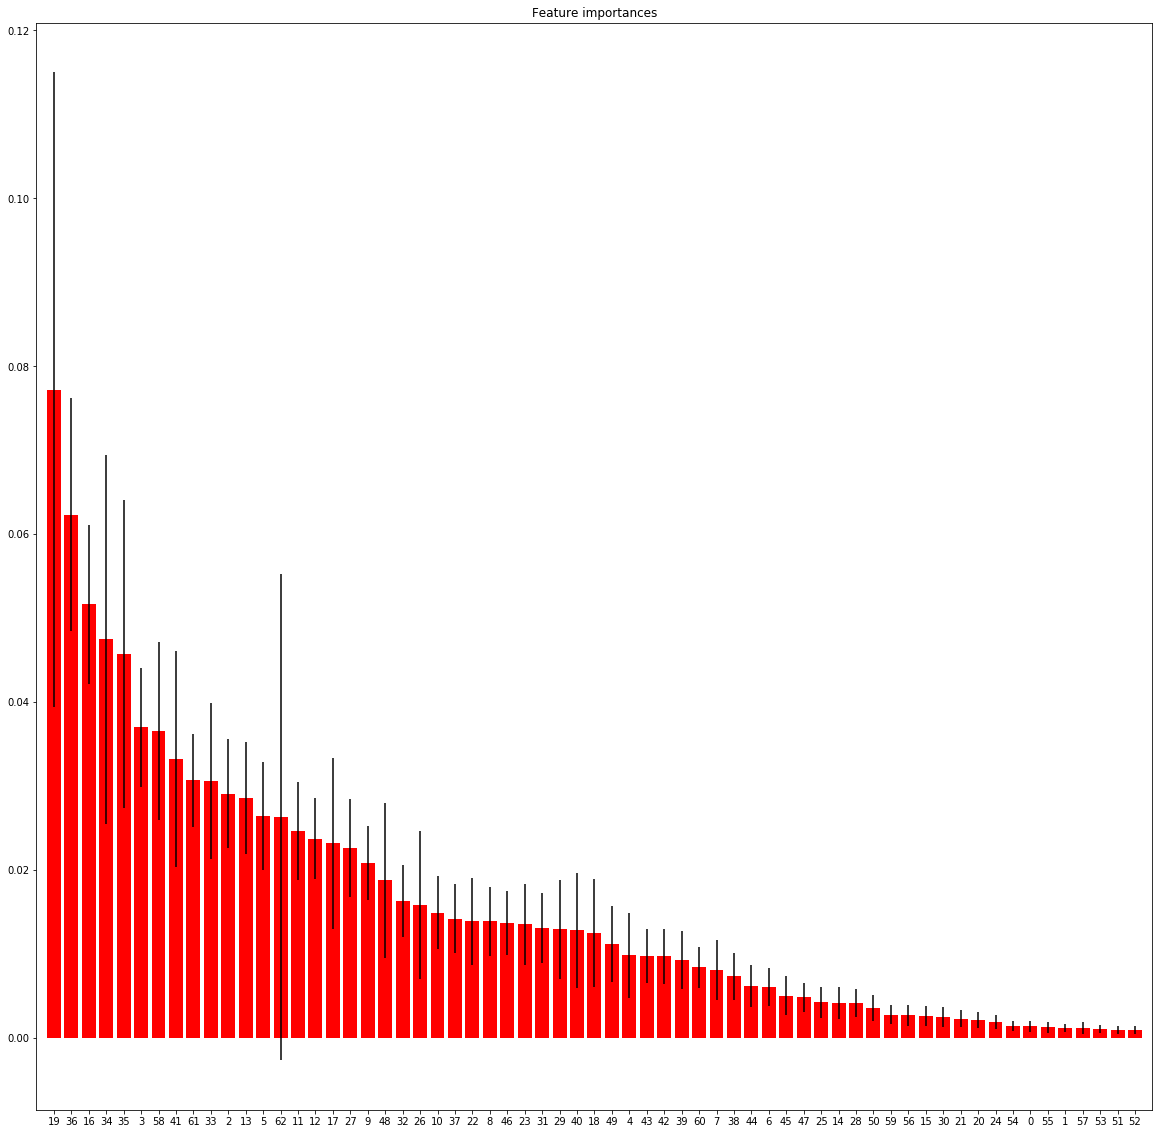

In [11]:
#%% GET THE FEATURES IMPORTANCE

def show_features(forest, X, y):
  importances = forest.feature_importances_

  # Calcola deviazione standard per plottare errore
  std = np.std([tree.feature_importances_ for tree in forest.estimators_],
              axis=0)
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print("Feature ranking:")

  for f in range(X.shape[1]):
      print("%d. feature %s (%f)" % (indices[f], features.columns[indices[f]], importances[indices[f]]))

  # Plot the feature importances of the forest
  plt.figure(figsize=(20,20))
  plt.title("Feature importances")
  plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()
  
show_features(forest, features, mywindow["ICB_INDUSTRY_NUM"])

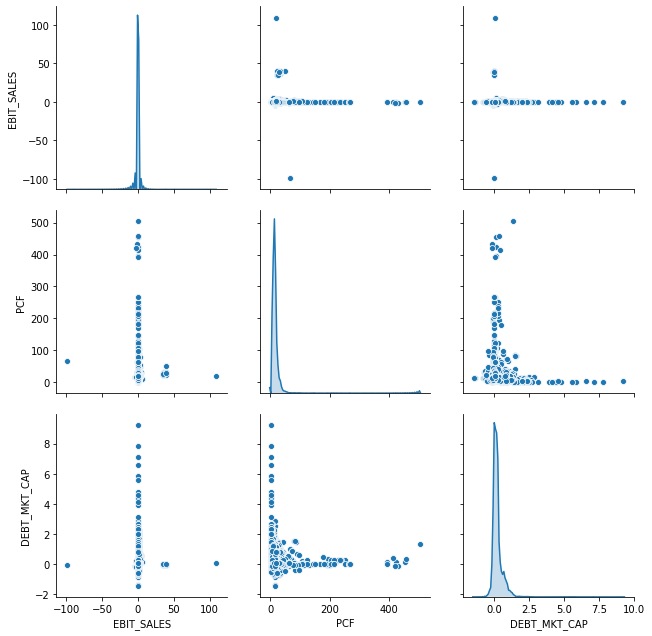

In [23]:
import seaborn as sns

sns.pairplot(features, height=3, vars=["EBIT_SALES", "PCF", "DEBT_MKT_CAP"],diag_kind="kde") 